<a href="https://colab.research.google.com/github/zhuatii/FPN_Covid19Diagnosis_CTImages/blob/main/FPN_Train%26Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights, ResNet18_Weights, resnet18
from torchvision import transforms, io
from sklearn.utils import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# os.environ['CUDA_LAUNCH_BLOCKING']= "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

## Creating Custom Dataset for loading the data to the models

In [5]:
### Paths to the dataframe containing
labels_path = "D:\github\CTData\Annotation\CSV"
images_path = "D:\github\CTData\TrainValidation"

train_folds = [os.path.join(labels_path,"train1.csv"),os.path.join(labels_path,"train2.csv"),
               os.path.join(labels_path,"train3.csv"), os.path.join(labels_path,"train4.csv"),
               os.path.join(labels_path,"train1.csv")]

val_folds = [os.path.join(labels_path,"validation1.csv"), os.path.join(labels_path,"validation2.csv"),
            os.path.join(labels_path,"validation3.csv"), os.path.join(labels_path,"validation4.csv"),
             os.path.join(labels_path,"validation5.csv")]

test_folds = [os.path.join(labels_path,"test1.csv"), os.path.join(labels_path,"test2.csv"),
            os.path.join(labels_path,"test3.csv"), os.path.join(labels_path,"test4.csv"),
             os.path.join(labels_path,"test5.csv")]

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\bswat\AppData\Local\Temp\ipykernel_6072\1490844544.py:2: SyntaxWarning: invalid escape sequence '\g'
  labels_path = "D:\github\CTData\Annotation\CSV"
C:\Users\bswat\AppData\Local\Temp\ipykernel_6072\1490844544.py:3: SyntaxWarning: invalid escape sequence '\g'
  images_path = "D:\github\CTData\TrainValidation"


In [6]:
class DataClass(Dataset):

    def __init__(self, annotations, transform = None):
        self.df = pd.read_csv(annotations)
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(images_path,self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if label == 'covid':
          target = 1
        else:
          target = 0
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.df)

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=0.05),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([transforms.ToTensor()])

In [8]:
i = 1 ### Takes values [0,1,2,3,4]. Eavh value of i loads a different dataset


TrainDataClass = DataClass(train_folds[i], train_transforms)
ValDataClass = DataClass(val_folds[i], test_transforms)
TestDataClass = DataClass(test_folds[i], test_transforms)

shape=(512,512,1)

In [9]:
len(TrainDataClass), len(ValDataClass), len(TestDataClass)

(3715, 915, 8343)

In [35]:
def ClassDist(data):
    dist = torch.Tensor([0,0])
    for _, label in data:
        dist[label]+=1
    return dist

<BarContainer object of 2 artists>

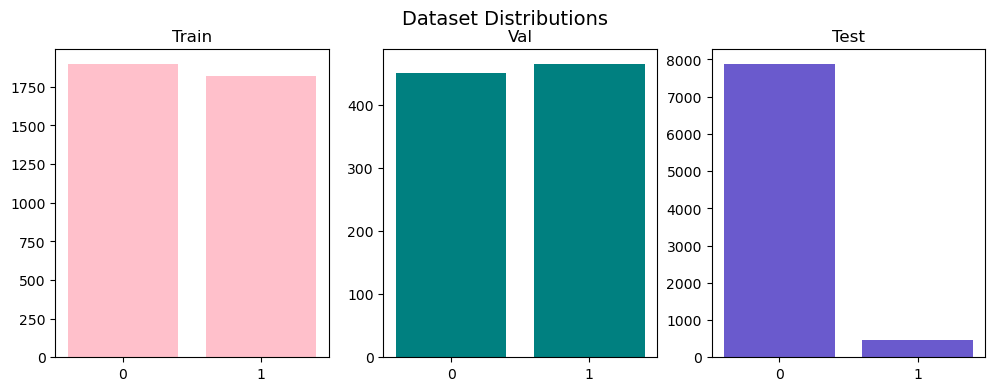

In [142]:
#[not covid, covid]
# trainDist = ClassDist(TrainDataClass)
# valDist = ClassDist(ValDataClass)
# testDist = ClassDist(TestDataClass)

classes = ['0','1']

plt.figure(figsize = (12,4))
plt.suptitle("Dataset Distributions", fontsize = 14)

fig1 = plt.subplot(1,3,1)
fig1.set_title("Train")
plt.bar(classes, trainDist, color = 'pink')

fig2 = plt.subplot(1,3,2)
fig2.set_title("Val")
plt.bar(classes, valDist, color = 'teal')

fig3 = plt.subplot(1,3,3)
fig3.set_title("Test")
plt.bar(classes,testDist, color = 'slateblue')

In [94]:
testDist

tensor([7878.,  465.])

In [10]:
### Data Loaders for the train, test and validation splits.

TrainDataLoader = DataLoader(TrainDataClass, batch_size = 14, shuffle = True)
ValDataLoader = DataLoader(ValDataClass, batch_size = 10, shuffle = False)
TestDataLoader = DataLoader(TestDataClass, batch_size = 10, shuffle = False)

## Implementation of the FPN architecture with ResNet backbone.

The implementation of the model proposed for Covid detection from CT images in the paper by Rahimzadeh et al. The model is huge with more trainable parameters than what my system could handle. I replicated the same for the pupose of learning how to build a PyTorch model from scratch with transfer learning. I used the Keras code given as reference along with the paper in the github [repo](https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb).

In [152]:
class FPNModel50(nn.Module):

    def __init__(self, num_classes = 2, feature_size = 64):
        super().__init__()
        shape=(512,512,1)   ### Specify the dimensions of the input image

        backbone = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

        input_size = shape
        feature_size = 64

        self.C1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)    #### Output filters = 64, image shape is now 256 x 256

        self.InputBlock = nn.Sequential(
            backbone._modules['bn1'],
            backbone._modules['relu'], 
            backbone._modules['maxpool']
        )                                       #### Output filters = 64, no change to image shape

        #### Extract layers for FPN
        self.layer_names = ["layer1", "layer2", "layer3", 'layer4']
        self.C2, self.C3, self.C4, self.C5 = [backbone._modules[name] for name in self.layer_names]

        ### C2 output filters = 256
        ### C3 output filters = 512
        ### C4 output filters = 1024
        ### C5 output filters = 2048
        ### All these modules preserve the image shape, i.e. (256 x 256)

        conv_layers = [self.InputBlock, self.C2, self.C3, self.C4, self.C5]

        ### Setting these parameters to be fixed and not to be learnt by the model
        for layer in conv_layers:                         
            for params in layer.parameters():
                params.requires_grad = False

        
        ### Layers for feature extraction: P3, P4, P5, P6, P7 : all aimed to maintain output dimension to 256x256
        self.P5 = nn.Conv2d(2048, feature_size, kernel_size=1, stride=1, padding=1).to(device)
        self.P4 = nn.Conv2d(1024, feature_size, kernel_size=1, stride=1, padding=1).to(device)
        self.P3 = nn.Conv2d(512, feature_size, kernel_size=1, stride=1, padding=1).to(device)
        
        self.P5_conv = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1).to(device)
        self.P4_conv = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1).to(device)

        self.P6 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=2).to(device)
        self.P7 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=2).to(device)

        # Classification layers
        def FPred():
            return nn.Sequential(
                nn.Flatten(),
                nn.Dropout(0.5),
                nn.Linear(256 * 256 * feature_size, num_classes),
                nn.ReLU()
            ).to(device)

        self.F1 = FPred()
        self.F2 = FPred()
        self.F3 = FPred()
        self.F4 = FPred()
        self.F5 = FPred()

        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5 * num_classes, 2),
            nn.Softmax(dim = 1)
        ).to(device)

    def forward(self, x):

        x = x.to(device, dtype=torch.float32)

        C1 = self.C1(x)
        C1 = C1.to(device)
        C1 = self.InputBlock(C1)
        C1 = C1.to(device)
        C2 = self.C2(C1)
        C2 = C2.to(device)
        C3 = self.C3(C2)
        C3 = C3.to(device)
        C4 = self.C4(C3)
        C4 = C4.to(device)
        C5 = self.C5(C4)
        C5 = C5.to(device)

        # FPN forward pass
        
        P5 = self.P5(C5)
        P5 = P5.to(device)
        P5_up = F.interpolate(P5, size=C4.shape[2:]) 
        P5_up = P5_up.to(device)
        P5 = self.P5_conv(P5)
        P5 = P5.to(device)

        P4 = self.P4(C4)
        P4 = P4.to(device)
        P4 = P4 + P5_up
        P4 = P4.to(device)
        P4_up = F.interpolate(P4, size=C3.shape[2:])
        P4_up = P4_up.to(device)
        P4 = self.P4_conv(P4)
        P4 = P4.to(device)

        P3 = self.P3(P3)
        P3 = P3.to(device)
        P3 = P3 + P4_up
        P3 = P3.to(device)

        P6 = self.P6(C5)
        P6 = P6.to(device)

        P7 = nn.ReLU(P6)
        P7 = P7.to(device)
        P7 = self.P7(P7)
        P7 = P7.to(device)

        F1 = self.F1(P3)
        F1 = F1.to(device)
        F2 = self.F2(P4)
        F2 = F2.to(device)
        F3 = self.F3(P5)
        F3 = F3.to(device)
        F4 = self.F4(P6)
        F4 = F4.to(device)
        F5 = self.F5(P7)
        F5 = F5.to(device)

        # Concatenate the features
        features = torch.cat([F1, F2, F3, F4, F5], dim=1)
        features = features.to(device)

        # Classification
        out = self.Classifier(features)
        out = out.to(device)

        return out

In [154]:
model = FPNModel50()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

42323488


The below model is a smaller modified version of the proposed model with **ResNet18** as the backbone for feature extraction. The below model has about 1 million parameters to be trained, and is thus implemented and tested. From the original architecture, the following changes have been made.

- The input figure is reduced to 1/4th its dimension as compared to the original, which reduces it to 1/2 in the first convolution layer.
- The number of layers in the FPN is reduced to 2 from 5.
- The number of features (filters) extracted from each layer of the FPN architecture is reduced to 3 from 256.

In [19]:
class FPNModel18(nn.Module):

    def __init__(self, num_classes = 2, feature_size = 64):
        super().__init__()
        shape=(512,512,1)

        backbone = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)

        input_size = shape
        feature_size = 3

        self.C1 = nn.Conv2d(1, 64, kernel_size=8, stride=4, padding=2, bias=False).to(device)

        #### Extract layers for FPN
        self.layer_names = ["layer1", "layer2"]
        self.C2, self.C3 = [backbone._modules[name] for name in self.layer_names]

        ### C2 output size = 64
        ### C3 output size = 128

        conv_layers = [self.C2, self.C3]

        for module in conv_layers:
          for params in module.parameters():
            params.requires_grad = False

        self.P3 = nn.Conv2d(128, feature_size, kernel_size=3, stride=1, padding=1).to(device)
        # self.P3_conv = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1).to(device)

        self.P2 = nn.Conv2d(64, feature_size, kernel_size=3, stride=2, padding=1).to(device)
        # self.P1 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1).to(device)

        # Classification layers
        self.FPred = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 64 * feature_size, num_classes),
            nn.ReLU()
        ).to(device)

        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * num_classes, 2),
            nn.Softmax(dim = 1)
        ).to(device)

    def forward(self, x):

        x = x.to(device, dtype=torch.float32)

        C1 = self.C1(x)
        C1 = C1.to(device)
        C2 = self.C2(C1)
        C2 = C2.to(device)
        C3 = self.C3(C2)
        C3 = C3.to(device)

        # FPN forward pass
        P3 = self.P3(C3)
        P3 = P3.to(device)
        # P3 = self.P3_conv(P3)
        # P3 = P3.to(device)

        P2 = self.P2(C2)
        P2 = P2.to(device)
        P2 = F.interpolate(P3, size=P2.shape[2:]) + P2
        P2 = F.relu(P2)

        F2 = self.FPred(P2)
        F2 = F2.to(device)
        F3 = self.FPred(P3)
        F3 = F3.to(device)

        # Concatenate the features
        features = torch.cat([F2, F3], dim=1)
        features = features.to(device)

        # Classification
        out = self.Classifier(features)
        out = out.to(device)

        return out

In [160]:
model = FPNModel18()
# model = FPNModel50()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

33874


## Model Training

In [172]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for (X,y) in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X).to(device)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(axis = 1) == y).type(torch.float).sum().item()

        test_loss = test_loss/batches
        correct = correct/ size
    print(f"Error: Average Loss = {test_loss:>8f}, Accuracy = {correct*100 :>0.1f}%")

In [182]:
num_epochs = 5
size = len(TrainDataLoader.dataset)
batches = len(TrainDataLoader)

for epoch in range(num_epochs):
    model.to(device)
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch+1} \n______________________________")
    for batch, (images, labels) in enumerate(TrainDataLoader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch%50 == 0:
            current = (batch+1)*len(images)    # No. of data points the model has been trained on
            loss = loss.item()          # Get the loss value of the current training sample
            print(f"Loss : {loss:>7f} [{current:>5d} / {size:>5d}]")
    
    print(f"Training error: Average Loss = {train_loss/batches:>8f}")  
    test(ValDataLoader, model, criterion)


Epoch 1 
______________________________
Loss : 0.632737 [   14 /  3715]
Loss : 0.514990 [  714 /  3715]
Loss : 0.459011 [ 1414 /  3715]
Loss : 0.651449 [ 2114 /  3715]
Loss : 0.490426 [ 2814 /  3715]
Loss : 0.477844 [ 3514 /  3715]
Training error: Average Loss = 0.522506
Error: Average Loss = 0.509321, Accuracy = 79.6%

Epoch 2 
______________________________
Loss : 0.631504 [   14 /  3715]
Loss : 0.410565 [  714 /  3715]
Loss : 0.435491 [ 1414 /  3715]
Loss : 0.403391 [ 2114 /  3715]
Loss : 0.486080 [ 2814 /  3715]
Loss : 0.572022 [ 3514 /  3715]
Training error: Average Loss = 0.514798
Error: Average Loss = 0.512488, Accuracy = 79.0%

Epoch 3 
______________________________
Loss : 0.488061 [   14 /  3715]
Loss : 0.394583 [  714 /  3715]
Loss : 0.480142 [ 1414 /  3715]
Loss : 0.588544 [ 2114 /  3715]
Loss : 0.435260 [ 2814 /  3715]
Loss : 0.537488 [ 3514 /  3715]
Training error: Average Loss = 0.519161
Error: Average Loss = 0.510266, Accuracy = 79.1%

Epoch 4 
________________________

In [168]:
model = torch.load("FPNFold2")

C:\Users\bswat\AppData\Local\Temp\ipykernel_6072\2404147224.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("FPNFold2")


In [190]:
torch.save(model, "FPNFold2")

The training loss is not desirable for the newly constructed model. The cross entropy loss is quite high. The possible ways to fix this is tuning the hyperparameters (learning rate) with the validation set or trying a different network architecture.

## Testing the Model Results

In [184]:
### Train Error

test(TrainDataLoader, model, criterion)

Error: Average Loss = 0.509335, Accuracy = 79.8%


In [185]:
### Test Error

test(TestDataLoader, model, criterion)

Error: Average Loss = 0.527472, Accuracy = 78.7%


### Confusion Matrix

In [186]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in TestDataLoader:
        outputs = model(inputs)
        
        # Get the predicted class 
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

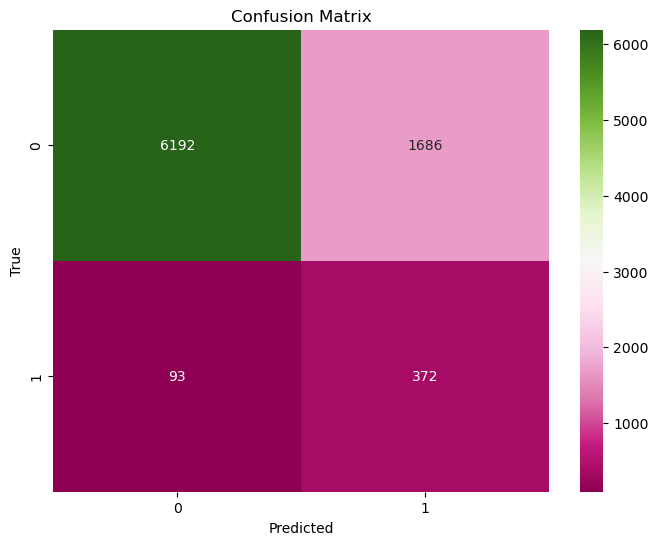

In [288]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="PiYG")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [188]:
TN = conf_matrix[0][0]
TP = conf_matrix[1][1]

FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

### Precision and Recall

In [200]:
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2*(TP) / (2*TP + FP+ FN)

print(f"Precision : {precision:>5f}")
print(f"Recall: {recall:5f}")
print(f"F1 Score: {f1_score:5f}")

Precision : 0.180758
Recall: 0.800000
F1 Score: 0.294887


## Sample Prediction

In [276]:
i = 90
inp = torch.Tensor(TestDataClass[i][0])
inp = inp.reshape([1, 1, 512, 512])

In [278]:
out = model(inp)
_, pred = torch.max(out, 1)
# inp.shape

In [286]:
TestDataClass[i][1], pred[0]

(1, tensor(1, device='cuda:0'))